# EVA
One of the fundamental algorithms in quantum computing is VQE, which seeks to find the state that minimizes a Hamiltonian. For this, a fundamental step is to know how to calculate the expected value of a state $|\phi\rangle$ through a Hamiltonian $H$, i.e., $\langle\phi|H|\phi \rangle$. To do so, if we have a Hamiltonian of the form:


$$\begin{equation}
H = \sum_{i=1}^n\alpha_i\sigma_z^i + \sum_{i = 1}^n\sum_{j = 1}^n\beta_{ij}\sigma_z^i\sigma_z^j,
\end{equation}
$$

We would have to run a circuit for each of its coefficients. The algorithm EVA [1], which we will develop in this tutorial, proposes a new method capable of estimating $$\langle\phi|H|\phi\rangle$$ with a single circuit.

## Main idea and implementation 

The first step is to remember that we can write the exponential as a Taylor series:

$$\begin{equation}
e^x = 1 + x + \frac{x^2}{2}+ \frac{x^3}{6}+...
\end{equation}$$

in particular, from our Hamiltonian equation (1) we arrive at:

$$\begin{equation}
\langle \phi|e^{iH/k}|\phi\rangle = I + i\frac{\langle\phi|H|\phi\rangle}{k} -\frac{\langle\phi|H^2|\phi\rangle}{2k^2} - i\frac{\langle \phi|H^3|\phi \rangle}{6k^3}+...
\end{equation}$$

Pennylane offers us the possibility to construct the exponential of a Hamiltonian ($e^{iH/k}$). Let's see an example of how to create the exponential of $H = 2Z_0 - 3Z_1Z_2$:


In [1]:
import pennylane as qml

H = qml.Hamiltonian([0.02,-0.03], [qml.PauliZ(wires = 0), qml.PauliZ(wires = 1) @ qml.PauliZ(wires = 2)])
k = 5

dev = qml.device("default.qubit", wires = 3)
@qml.qnode(dev)
def evolution():
    qml.templates.ApproxTimeEvolution(H, -1/k, 1)
    return qml.state()
    
print(qml.draw(evolution)())

 0: ───RZ(-0.008)──╭┤ State 
 1: ──╭RZ(0.012)───├┤ State 
 2: ──╰RZ(0.012)───╰┤ State 



Therefore, we already know that constructing the exponential of the Hamiltonian is possible. To guarantee a good approximation of the method it is necessary that the Hamiltonian is normalized, i.e., $|H| \leq 1$. The next step is to clear from the development of the exponential to get:

$$\begin{equation}
\tag{4}
\langle\phi|H|\phi \rangle = \lim_{k\rightarrow\infty} k\text{Im}(\langle\phi|e^{iH/k}|\phi\rangle).
\end{equation}$$

That is, our expected value is the limit of $k$ by the imaginary part of the exponential. The next step is to calculate our operator's imaginary part, which can be obtained simply through the Hadamard Test.

<img src="eva.png" width=400 height=240 />
The imaginary part would be obtained as the expected value over the first qubit. To build this circuit, we must first define the Hamiltonian and the state $|\phi\rangle$ on which we want to calculate $\langle\phi|H|\phi\rangle$. For which we will define a Hamiltonian (which, like the reference paper, will be of degree 3) and an ansatz.

In [2]:
from pennylane import numpy as np

p = 0.8 
size = 12 # number of qubits

obs = []
for j in range(size):
    if np.random.rand() < p :obs.append(qml.PauliZ(wires = j))
        
    for i in range(j+1,size):
        if np.random.rand() < p :obs.append(qml.PauliZ(wires = j) @ qml.PauliZ(wires = i))
            
        for k in range(i+1,size):
            if np.random.rand() < p :obs.append(qml.PauliZ(wires = j) @ qml.PauliZ(wires = i) @ qml.PauliZ(wires = k))
        

coefs = (np.random.rand(len(obs))-0.5)
coefs = coefs / sum([abs(i) for i in coefs]) # we normalize the coefficients


H = qml.Hamiltonian(coefs, obs)

size = len(H.wires)
w = np.random.rand(size) * np.pi

def ansantz(w, wires = list(range(size))):
    for i in wires:
        qml.RX(w[i], wires = i)
        qml.CNOT(wires = [i, (i + 1) % size])

The algorithm would be defined from the following scheme:

In [3]:
shots = 2000
k = 4
       
@qml.template
def evolution():
    qml.templates.ApproxTimeEvolution(H, -1/k, 1)
    
ops = qml.ctrl(evolution, control = size)
dev = qml.device("default.qubit", size + 1, shots = int(len(H.coeffs) * shots * k ** 2))

@qml.qnode(dev)
def model(w):
    ansantz(w)
    qml.Hadamard(wires = size)
    qml.RZ(-np.pi/2, wires = size)
    ops()
    qml.Hadamard(wires = size)
    return qml.expval(qml.PauliZ(wires = size))

def EVA(w):
    return model(w) * k 

print("EVA: expected value:", EVA(w))

EVA: expected value: -0.024051255230125523


This method is expensive because many Toffoli gates appear when performing a control operation on the exponential gate. Let's see how many we are using in this case:

In [4]:
model.specs['gate_sizes']

defaultdict(int, {1: 15, 2: 251, 3: 812})

## Reduced EVA 
For this reason, we propose an improvement on this algorithm to reduce the number of gates needed to calculate our expected value, the reduced EVA. In this case, we have found a circuit that, under certain conditions, maintains the equivalence with the previous algorithm:

<img src="reva.png" width=500 height=240 />

In [5]:
@qml.template
def hadamards():
    for i in range(size):
        qml.Hadamard(wires = i)
    
    
ops2 = qml.ctrl(hadamards, control = size)

@qml.qnode(dev)
def model2(w):
    ansantz(w)
    qml.Hadamard(wires = size)
    qml.RZ(np.pi/2, wires = size)
    ops2()
    qml.templates.ApproxTimeEvolution(H, -1/k, 1)
    ops2()
    qml.Hadamard(wires = size)
    return qml.expval(qml.PauliZ(wires = size))

def reducedEVA(w):
    return model2(w) * k 

print("expected value:", reducedEVA(w))

expected value: -0.024824267782426777


In [6]:
model2.specs['gate_sizes']

defaultdict(int, {1: 25, 2: 136, 3: 177})

We can observe the difference in the number of gates used, decreasing the number of Toffoli gates considerably. This approximation can be only done if the ansatz is formed only by CNOT or RX gates, but it does not pose any problem when minimizing Hamiltonian problems on a single axis.

In [7]:
def vqe(w):
    dev2 = qml.device("default.qubit", size, shots = shots)
    cost_fn = qml.ExpvalCost(ansantz, H, dev2, optimize = True)
    return cost_fn(w)

print("VQE, expected value:", vqe(w))

VQE, expected value: -0.023943312413878006


As a curiosity, here we leave the calculation through the optimized VQE algorithm to compare the results. As can be seen, the approximations are adequate.

## Comparative study with VQE

Next, we will show a comparison in time as the size of our Hamiltonian grows:

From 9 to 18 qubits:
9 qubits
10 qubits
11 qubits
12 qubits
13 qubits
14 qubits
15 qubits
16 qubits
17 qubits
18 qubits


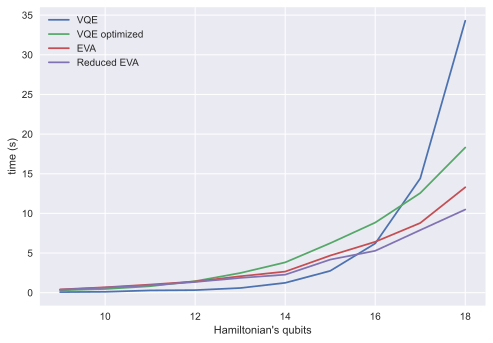

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import numpy as np
from pennylane.templates import ApproxTimeEvolution
from time import time

prob = 0.75 

time_eva, time_eva_reduced, time_vqe, time_vqe_compacted = [],[],[],[]
rango = range(9,19,1)
lista = list(rango)
print(f"From {lista[0]} to {lista[-1]} qubits:")
for size in rango:
    print(size, "qubits")
    
    obs = []
    for j in range(size):
        if np.random.rand() < prob :obs.append(qml.PauliZ(wires = j))

        for i in range(j+1,size):
            if np.random.rand() < prob :obs.append(qml.PauliZ(wires = j) @ qml.PauliZ(wires = i))

            for k in range(i+1,size):
                if np.random.rand() < prob :obs.append(qml.PauliZ(wires = j) @ qml.PauliZ(wires = i) @ qml.PauliZ(wires = k))


    coefs = (np.random.rand(len(obs))-0.5)*2
    coefs = coefs / sum([abs(i) for i in coefs])


    H = qml.Hamiltonian(coefs, obs)
    
    shots = 2000
    k = 4
    wires = len(H.wires)
    cofs = len(H.coeffs)
    w = np.random.rand(wires)*2*np.pi

    def ansantz(w, wires = list(range(wires))):
        for i in wires:
            qml.RX(w[i], wires = i)


    @qml.template
    def evolution():
        qml.templates.ApproxTimeEvolution(H, -1/k, 1)

    ops = qml.ctrl(evolution, control = size)
    dev = qml.device("default.qubit", size + 1, shots = int(len(H.coeffs) * shots * k ** 2))

    @qml.qnode(dev)
    def model(w):
        ansantz(w)
        qml.Hadamard(wires = size)
        qml.RZ(-np.pi/2, wires = size)
        ops()
        qml.Hadamard(wires = size)
        return qml.expval(qml.PauliZ(wires = size))

    def EVA(w):
        return model(w) * k 


    @qml.template
    def hadamards():
        for i in range(size):
            qml.Hadamard(wires = i)


    ops2 = qml.ctrl(hadamards, control = size)

    @qml.qnode(dev)
    def model2(w):
        ansantz(w)
        qml.Hadamard(wires = size)
        qml.RZ(np.pi/2, wires = size)
        ops2()
        qml.templates.ApproxTimeEvolution(H, -1/k, 1)
        ops2()
        qml.Hadamard(wires = size)
        return qml.expval(qml.PauliZ(wires = size))

    def reducedEVA(w):
        return model2(w) * k 


    def vqe_optimize(w):
        dev2 = qml.device("default.qubit", size, shots = shots)
        cost_fn = qml.ExpvalCost(ansantz, H, dev2, optimize = True)
        return cost_fn(w)
    
    def vqe(w):
        dev2 = qml.device("default.qubit", size, shots = shots)
        cost_fn = qml.ExpvalCost(ansantz, H, dev2, optimize = False)
        return cost_fn(w)

    def duration(f, w):
        time1 = time()
        f(w)
        sol = time() - time1
        return sol


    time_eva.append(duration(EVA, w))
    time_eva_reduced.append(duration(reducedEVA, w))
    time_vqe.append(duration(vqe, w))
    time_vqe_compacted.append(duration(vqe_optimize, w))
    
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
plt.style.use("seaborn")

plt.plot(rango,time_vqe, label = "VQE")
plt.plot(rango,time_vqe_compacted, label = "VQE optimized")
plt.plot(rango,time_eva, label = "EVA")
plt.plot(rango,time_eva_reduced, label = "Reduced EVA")
plt.legend()
plt.xlabel("Hamiltonian's qubits")
plt.ylabel("time (s)")
plt.show()

In the comparison, we can see how, in this case, the calculation time through the EVA algorithm is less than that used by the VQE method, both traditional and optimized.

## References


[1] Alonso-Linaje G, Atchade-Adelomou P. EVA: a quantum Exponential Value Approximation algorithm. arXiv preprint arXiv:2106.08731. 2021 Jun 16. <https://arxiv.org/pdf/2107.12375>
